# A Snapshot of Gender Bias in book titles
Uses ~ 4.4 million books from HathiTrust.

Currently I focus on all books published but I could limit to all books published from 1800 onwards, 1900 onwards, etc. if that makes more sense. My reasoning for including all book titles was that the LCSH was made (in theory) for all existing books so even though it was only created in the late 1800s early 1900s, it should still account for books published before then. 

TLDR: There is asymmetry in book titles (more tiles that mention women than men), however the historical trends are interesting -- the imbalance flipped and there have been way more books with titles that mention women published in recent decades

Needs to generate file: english-hathi.pkl using code in Data/HathiTrust folder

In [2]:
import pickle
from Code import lcshFunctions as lcFunc
from Code import plottingFunctions as pltFunc
import numpy as np
import math
import matplotlib.pyplot as plt

### Functions

In [3]:
def percent(subset, total):
    return subset/total*100

def cleanTitles(books):
    for idx, book in books.items():
        title = book['title']
        if ' / ' in title:
            title = title.split('/')[0]
        if '[' in title and ']' in title:
            title = title.split('[')[0]
        if '$b' in title:
            title = title.split('$b')[0]
        if ', by' in title:
            title = title.split(', by')[0]
        elif '. by' in title:
            title = title.split('. by')[0]
        elif '. By' in title:
            title = title.split('. By')[0]
        if ', edited' in title:
            title = title.split(', edited')[0]
        elif '. edited' in title:
            title = title.split('. edited')[0]
        elif '. Edited' in title:
            title = title.split('. Edited')[0]
        if ', translated' in title:
            title = title.split(', translated')[0]
        elif '. translated' in title:
            title = title.split('. translated')[0]
        elif '. Translated' in title:
            title = title.split('. Translated')[0]
        if '. Compiled' in title:
            title = title.split('. Compiled')[0]
        elif ', compiled' in title:
            title = title.split(', compiled')[0]
        elif '. compiled' in title:
            title = title.split('. compiled')[0]
        elif ', compiled' in title:
            title = title.split('. compiled')[0]
        if ', illustrated' in title:
            title = title.split(', illustrated')[0]
        elif '. Illustrated' in title:
            title = title.split('. Illustrated')[0]
        elif '. illustrated' in title:
            title = title.split('. illustrated')[0]
        books[idx]['title'] = title
    return books

def getTitlesWithWords(books, wordList, tag):
    booksWithWords = {}
    for idx, book in books.items():
        flag = False
        title = lcFunc.clean(book['title'])
        words = [w for w in title.split(' ')]
        for w in wordList:
            if w in words:
                book[tag] = w
                book['baseForm'] = title
                flag = True
                break
        if flag:
            booksWithWords[idx] = book
    return booksWithWords

Load book titles

In [4]:
with open('Data/HathiTrust/englishHathi.pkl', 'rb') as f:
    bookTitles = pickle.load(f)
bookTitles = cleanTitles(bookTitles)

Get gendered book titles

In [5]:
words4women = lcFunc.readWordList('Data/terms4women.txt')
words4men = lcFunc.readWordList('Data/terms4men.txt')
print(f'There are {len(words4men)} words used to identify terms for men and {len(words4women)} for women.')

mTitles = getTitlesWithWords(bookTitles, words4men, 'genTerm')
wTitles = getTitlesWithWords(bookTitles, words4women, 'genTerm')
print(words4men, words4women)

There are 4 words used to identify terms for men and 4 for women.
['men', 'gentlemen', 'male', 'masculine'] ['women', 'ladies', 'female', 'feminine']


In [6]:
inBoth = lcFunc.getAmbiguous(mTitles, wTitles, )
lcFunc.pruneAmbiguous(mTitles, wTitles, inBoth, 'title', 'Data/HathiTrust/ambiguousTitles.txt')


This will be imperfect because of th set of words I use for men and women. Some of the titles in the women set mention 'lords and ladies' because lords is not a term i use to identify books for men and the converse is true for books that discuss gentlemen and gentlewomen. I could specifically prune these cases but they only account for at most 20 books so I don't think its a major issue. 

In [7]:
total = len(mTitles)+len(wTitles)
print(f'There are {len(bookTitles):,} book titles and {total:,} ({percent(total, len(bookTitles)):.2f}%) are gendered.\n\t{len(mTitles):,} ({percent(len(mTitles), total):.2f}%) mention men\n\t{len(wTitles):,} ({percent(len(wTitles), total):.2f}%) mention women.')

with open('Data/HathiTrust/men-titles.txt', 'w') as f:
    for term in mTitles.values():
        f.write(f'{term['title']}\n')

with open('Data/HathiTrust/women-titles.txt', 'w') as f:
    for term in wTitles.values():
        f.write(f'{term['title']}\n')

There are 4,402,427 book titles and 53,463 (1.21%) are gendered.
	16,861 (31.54%) mention men
	36,602 (68.46%) mention women.


I remove all books with a date of 9999 as that means the publication date could not be determined from the source. The percentages stay consistent when these books are removed (and they only amount to 435 books)

In [8]:
mWithDate = {idx:book for idx, book in mTitles.items() if int(book['date']) != 9999}
wWithDate = {idx:book for idx, book in wTitles.items() if int(book['date']) != 9999}
totalWithDate = len(mWithDate)+len(wWithDate)
print(f'There are {totalWithDate:,} ({percent(totalWithDate, total):.2f}%) gendered titles with dates.\n\t{len(mWithDate):,} ({percent(len(mWithDate), totalWithDate):.2f}%) mention men\n\t{len(wWithDate):,} ({percent(len(wWithDate), totalWithDate):.2f}%) mention women')

There are 53,028 (99.19%) gendered titles with dates.
	16,726 (31.54%) mention men
	36,302 (68.46%) mention women


I report the earliest book, the most recent book, and the median year of publication. It appears that books with titles that mention women tend to be published later than books with titles that mention men. 

In [9]:
mDates = [int(book['date']) for book in mWithDate.values()]
wDates = [int(book['date']) for book in wWithDate.values()]
print('Men:', min(mDates), max(mDates), np.median(mDates))
print('Women:', min(wDates), max(wDates), np.median(wDates))

Men: 1561 2023 1928.0
Women: 1197 2023 1987.0


I focus on how things change each decade from 1900 until 2023 as that is around when the LCSH was first being conceptualized (although it would probably be applied to a much more limited/american set of books than it currently is?)

In [10]:
labels = ['<1900', '1900s', '1910s', '1920s', '1930s', '1940s', '1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s', '2020s']

mDecades = np.zeros(14)
for date in mDates:
    if date < 1900:
        mDecades[0] += 1
    else:
        mDecades[math.floor((date-1900)/10)+1] += 1

wDecades = np.zeros(14)
for date in wDates:
    if date < 1900:
        wDecades[0] += 1
    else:
        wDecades[math.floor((date-1900)/10)+1] += 1

<Axes: ylabel='Proportion of New Titles'>

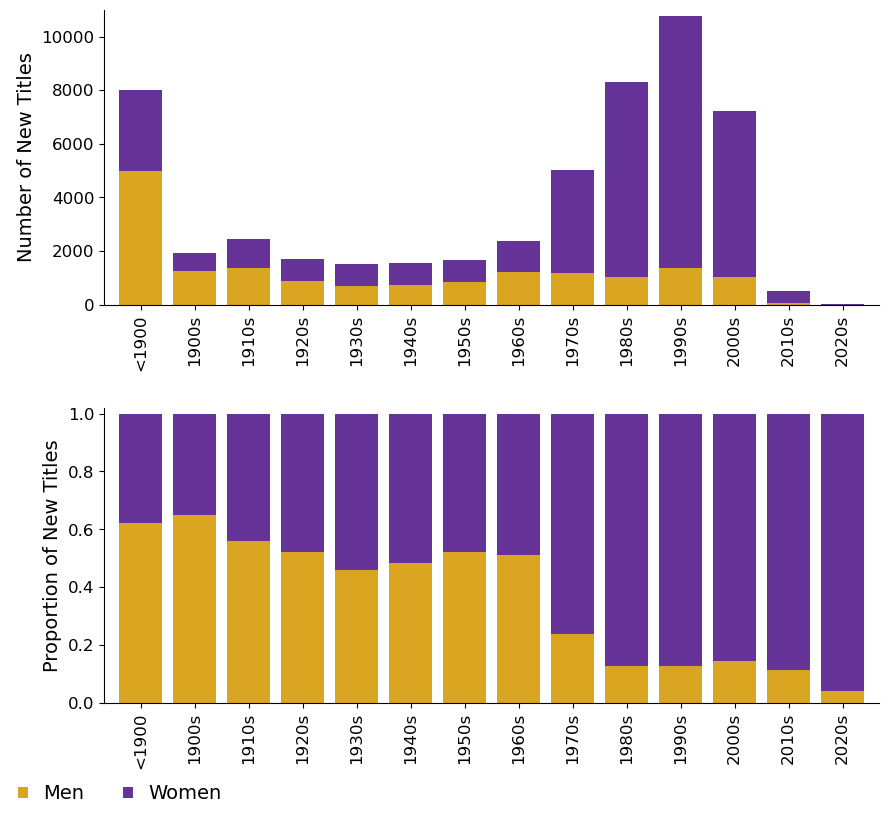

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(10, 9))
ax1, ax2 = axes
total = np.add(mDecades, wDecades)

new = {
    "Men": mDecades,
    "Women": wDecades
}
pltFunc.plotStacked(ax1, labels, new, ['goldenrod', 'rebeccapurple'], yLabel='Number of New Titles', legend=False)

propW = [wDecades[i]/total[i] for i in range(len(wDecades))]
propM = [mDecades[i]/total[i] for i in range(len(mDecades))]
propNew = {
    "Men": propM,
    "Women": propW,
}
pltFunc.plotStacked(ax2, labels, propNew, ['goldenrod', 'rebeccapurple'], yLabel='Proportion of New Titles')

<Axes: ylabel='Proportion of Titles'>

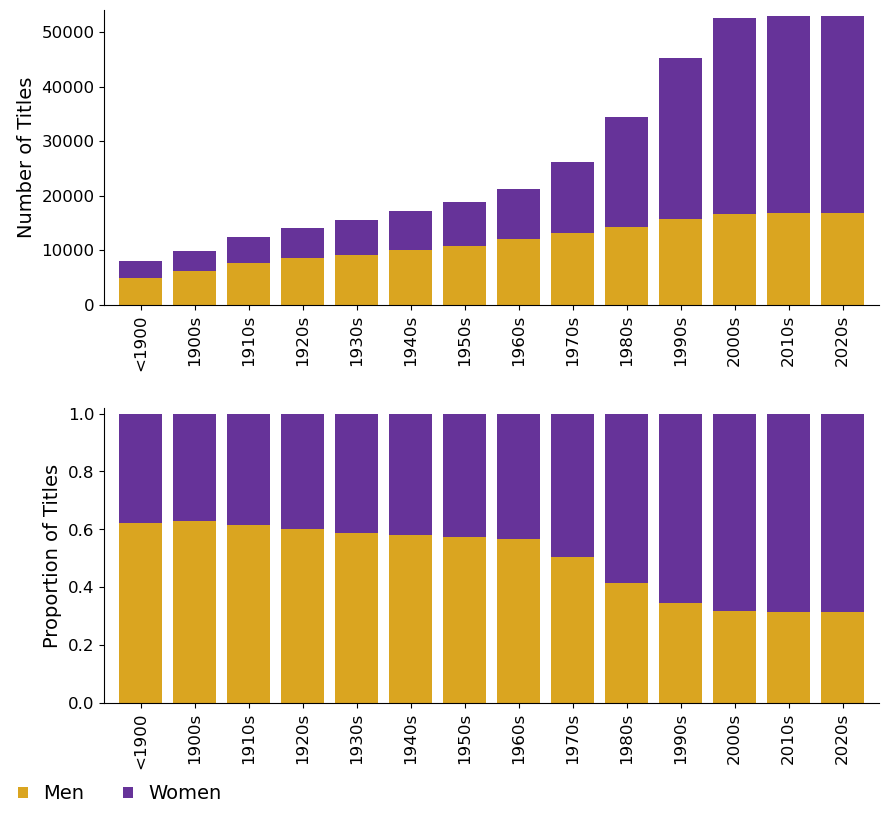

In [12]:
mCulm = np.cumsum(mDecades)
wCulm = np.cumsum(wDecades)
total = np.add(mCulm, wCulm)


fig, axes = plt.subplots(2, 1, figsize=(10, 9))
ax1, ax2 = axes

culm = {
    "Men": mCulm,
    "Women": wCulm
}
pltFunc.plotStacked(ax1, labels, culm, ['goldenrod', 'rebeccapurple'], yLabel='Number of Titles', legend=False)

propW = [wCulm[i]/total[i] for i in range(len(wCulm))]
propM = [mCulm[i]/total[i] for i in range(len(mCulm))]
propCulm = {
    "Men": propM,
    "Women": propW,
}
pltFunc.plotStacked(ax2, labels, propCulm, ['goldenrod', 'rebeccapurple'], yLabel='Proportion of Titles')


And then I focus on each year from 1990 until 2023 to keep it consistent with the LCSH analysis 

In [16]:
years = np.arange(1979, 2024)
mYears = np.zeros(years.shape[0])
for date in mDates:
    if date < 1980:
        mYears[0] += 1
    else:
        mYears[date-1979] += 1

wYears = np.zeros(years.shape[0])
for date in wDates:
    if date < 1980:
        wYears[0] += 1
    else:
        wYears[date-1979] += 1

<Axes: ylabel='Proportion of New Titles'>

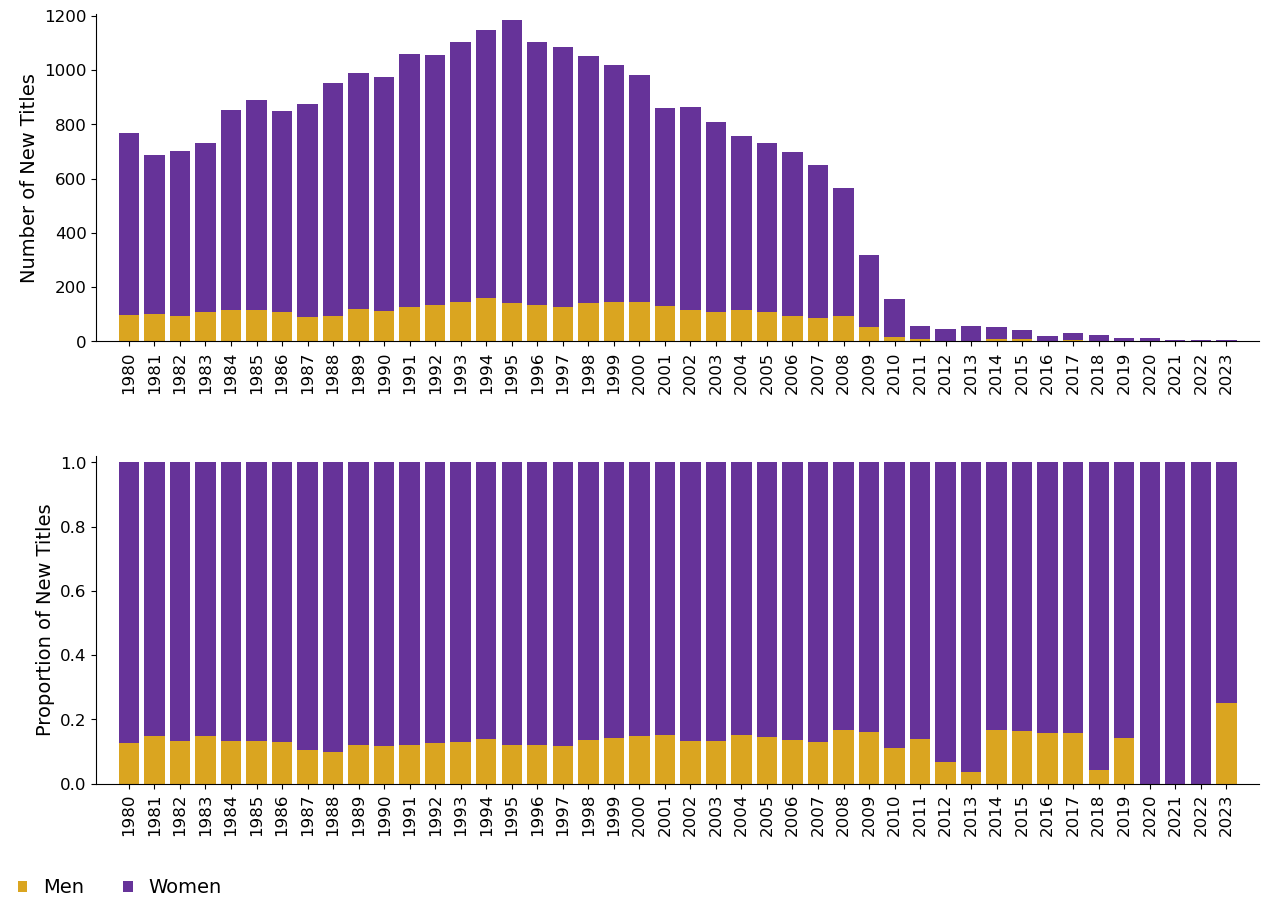

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
ax1, ax2 = axes
total = np.add(mYears, wYears)

new = {
    "Men": mYears[1:],
    "Women": wYears[1:]
}
pltFunc.plotStacked(ax1, years[1:], new, ['goldenrod', 'rebeccapurple'], yLabel='Number of New Titles', legend=False)

propW = [wYears[i]/total[i] for i in range(len(wYears))]
propM = [mYears[i]/total[i] for i in range(len(mYears))]
propNew = {
    "Men": propM[1:],
    "Women": propW[1:],
}
pltFunc.plotStacked(ax2, years[1:], propNew, ['goldenrod', 'rebeccapurple'], yLabel='Proportion of New Titles')

<Axes: ylabel='Proportion of New Titles'>

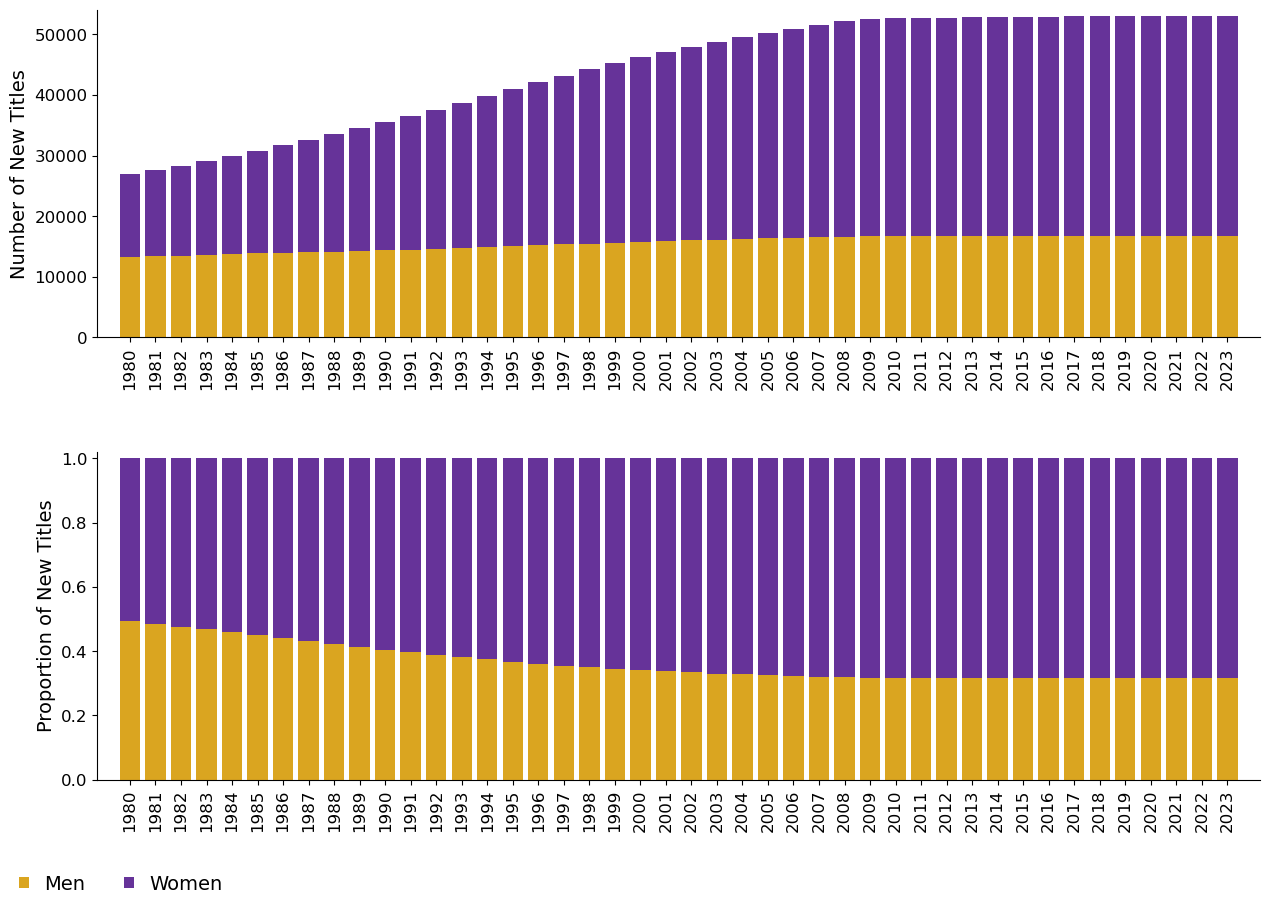

In [18]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
ax1, ax2 = axes
mCulm = np.cumsum(mYears)
wCulm = np.cumsum(wYears)
total = np.add(mCulm, wCulm)

new = {
    "Men": mCulm[1:],
    "Women": wCulm[1:]
}
pltFunc.plotStacked(ax1, years[1:], new, ['goldenrod', 'rebeccapurple'], yLabel='Number of New Titles', legend=False)

propW = [wCulm[i]/total[i] for i in range(len(wCulm))]
propM = [mCulm[i]/total[i] for i in range(len(mCulm))]
propNew = {
    "Men": propM[1:],
    "Women": propW[1:],
}
pltFunc.plotStacked(ax2, years[1:], propNew, ['goldenrod', 'rebeccapurple'], yLabel='Proportion of New Titles')

Hathi Dataset not great post 2010

In [33]:
booksWithDates = [int(book['date']) for book in bookTitles.values() if int(book['date']) <= 2023]
print(f'There are {len(booksWithDates):,} books with valid dates ({percent(len(booksWithDates), len(bookTitles)):.2f}%)')

There are 4,336,977 books with valid dates (98.51%)


In [36]:
years = np.arange(1979, 2024)
allBooks = np.zeros(years.shape[0])
for date in booksWithDates:
    if date < 1980:
        allBooks[0] += 1
    elif date <= 2023:
        allBooks[date-1979] += 1
print(f'The median date of publication for all books is {np.median(booksWithDates):.0f}')

The median date of publication for all books is 1970


In [39]:
print('All:', min(booksWithDates), max(booksWithDates), np.median(booksWithDates))

All: 16 2023 1970.0


<Axes: ylabel='Number of New Titles'>

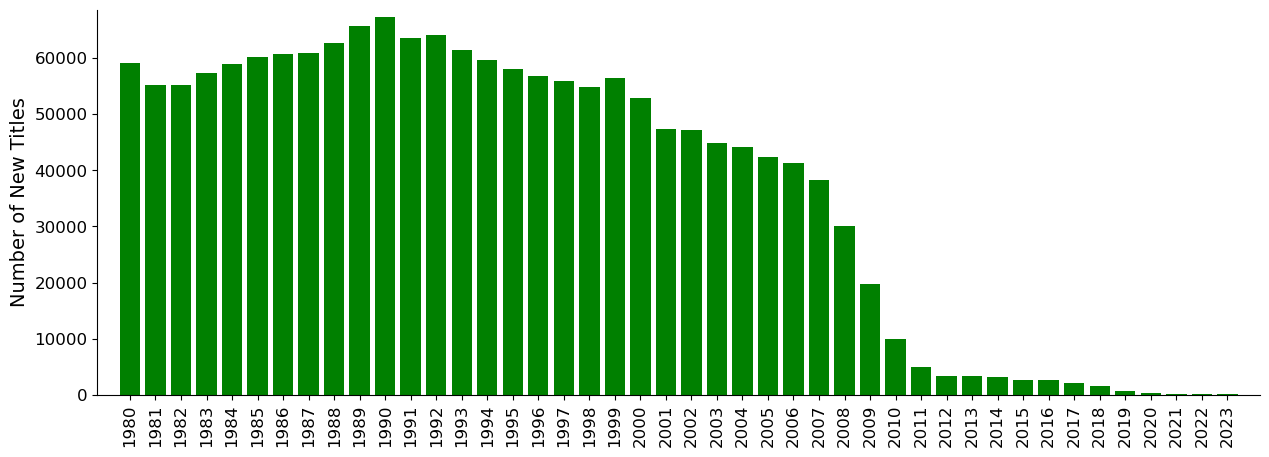

In [31]:
fig, axes = plt.subplots(1, 1, figsize=(15, 5))
ax1 = axes
total = np.add(mYears, wYears)

new = {
    "Books": allBooks[1:],
}
pltFunc.plotStacked(ax1, years[1:], new, ['green'], yLabel='Number of New Titles', legend=False)